Fetching data for Pune from 1990 to 2025...
✅ Data collected successfully. Rows: 13076
✅ Model saved successfully as pune_xgb_model.pkl

--- Model Evaluation for Pune ---
✅ R² Score: 0.9401
✅ RMSE: 0.3636
---------------------------------



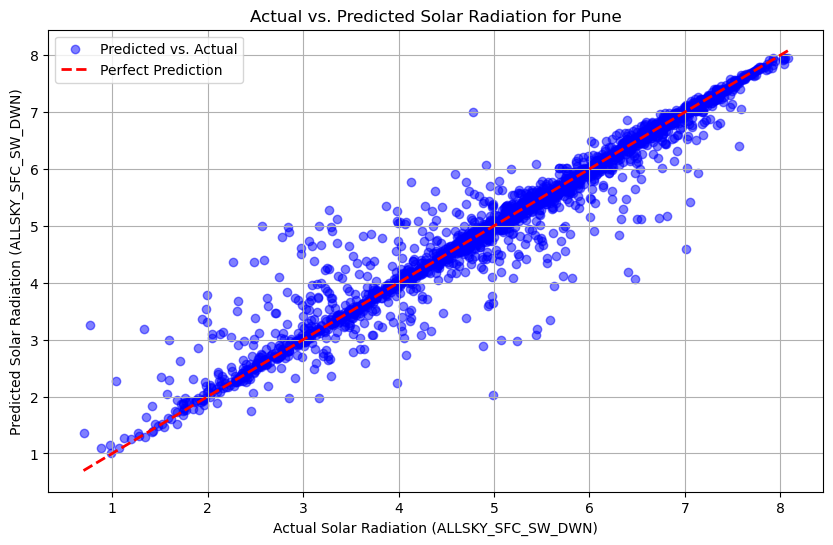

In [5]:
# 1. Import Libraries
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib  # <-- NEW LINE: Import joblib to save the model

# 2. Define Parameters for Pune
city = "Pune"
latitude = 18.5246
longitude = 73.8786
start_year = 1990
end_year = 2025

# 3. Function to get NASA POWER data
def fetch_weather_data(lat, lon, start_year, end_year):
    # (This function is correct and doesn't need changes)
    start_date = f"{start_year}0101"
    end_date = f"{end_year}1231"
    parameters = (
        "ALLSKY_SFC_SW_DWN,T2M,RH2M,WS2M,"
        "PRECTOTCORR,PS,CLRSKY_SFC_SW_DWN,ALLSKY_KT"
    )
    base_url = (
        f"https://power.larc.nasa.gov/api/temporal/daily/point?"
        f"parameters={parameters}&start={start_date}&end={end_date}&"
        f"latitude={lat}&longitude={lon}&community=RE&format=JSON"
    )
    print(f"Fetching data for {city} from {start_year} to {end_year}...")
    try:
        response = requests.get(base_url, timeout=60)
        if response.status_code == 200:
            data = response.json()
            if 'properties' in data and 'parameter' in data['properties']:
                params = data['properties']['parameter']
                df = pd.DataFrame(params)
                df.index = pd.to_datetime(df.index, format='%Y%m%d')
                df.index.name = 'Date'
                df = df.reset_index()
                print(f"✅ Data collected successfully. Rows: {len(df)}")
                return df
            else:
                print("❌ Malformed data received.")
                return pd.DataFrame()
        else:
            print(f"❌ Failed to fetch data. Status: {response.status_code}")
            return pd.DataFrame()
    except requests.exceptions.RequestException as e:
        print(f"❌ Network error: {e}")
        return pd.DataFrame()

# 4. Fetch the data
final_df = fetch_weather_data(latitude, longitude, start_year, end_year)

if not final_df.empty:
    # 5. Feature Engineering
    final_df['Month'] = final_df['Date'].dt.month
    final_df['DayOfYear'] = final_df['Date'].dt.dayofyear
    final_df['Weekday'] = final_df['Date'].dt.dayofweek

    # 6. Define Features and Target
    features = [
        'T2M', 'RH2M', 'WS2M', 'PRECTOTCORR', 'PS',
        'CLRSKY_SFC_SW_DWN', 'ALLSKY_KT', 'Month', 'DayOfYear', 'Weekday'
    ]
    target = 'ALLSKY_SFC_SW_DWN'

    X = final_df[features]
    y = final_df[target]

    # 7. Handle Missing Values
    X = X.replace(-999, np.nan).fillna(X.mean())
    y = y.replace(-999, np.nan).fillna(y.mean())

    # 8. Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 9. Train the XGBoost Model
    model = XGBRegressor(n_estimators=150, learning_rate=0.1, max_depth=7, random_state=42, objective='reg:squarederror')
    model.fit(X_train, y_train)
    
    # --- NEW SECTION: SAVE THE MODEL ---
    # Save the trained model to a file named 'pune_xgb_model.pkl'
    joblib.dump(model, "pune_xgb_model.pkl")
    print("✅ Model saved successfully as pune_xgb_model.pkl")
    # ------------------------------------

    # 10. Evaluate the Model
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"\n--- Model Evaluation for {city} ---")
    print(f"✅ R² Score: {r2:.4f}")
    print(f"✅ RMSE: {rmse:.4f}")
    print("---------------------------------\n")

    # 11. Visualize Results
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Predicted vs. Actual')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2, label='Perfect Prediction')
    plt.xlabel("Actual Solar Radiation (ALLSKY_SFC_SW_DWN)")
    plt.ylabel("Predicted Solar Radiation (ALLSKY_SFC_SW_DWN)")
    plt.title("Actual vs. Predicted Solar Radiation for Pune")
    plt.grid(True)
    plt.legend()
    plt.show()